## Analyze all single mutant neutralization data 
We generated single mutant reporter virus particles (RVPs) based on DMS differential selection analysis. These RVPs have a GFP based readout that we analyzed via high throughput flow cytometry. Now, we want to determine if single mutations contributed to antibody neutralization resistance or antibody escape. We also want to make figures for the paper. 

In [1]:
# Import packages
import pandas as pd
import os
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import scipy.stats
from IPython.display import HTML, display
from statsmodels.sandbox.stats.multicomp import multipletests
import operator
from functools import reduce

import neutcurve

In [2]:
# Set pandas display options
pd.set_option('display.float_format', '{:.4g}'.format)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

In [3]:
## ID sequences and locations
datadir = './data'
resultsdir ='./results'
os.makedirs(datadir, exist_ok = True)
os.makedirs(resultsdir, exist_ok = True)

# ID antibody and experiment number
ab_dict = {'C10': 'CC60',
           'C8': 'CC60',
           'SiGN3C': 'CC60',
           'MZ4': 'CC60',
           'ZV67': 'CK071',
          }


### Calculate fraction infectivity
Based on Kate Crawford's SARS-CoV-2 JID paper, we get calculate fraction infectivity by dividing individual datapoints by the average of no-antibody or no-serum controls.

In [4]:
neutcurve_ls = []

for antibody in ab_dict:
    # ID sequence
    platereader_datafile = os.path.join(datadir,f'{antibody}_{ab_dict[antibody]}_neutdata.csv')
    platereader = pd.read_csv(platereader_datafile)
    
    # Get list of unique viruses and sort them by the mutated site
    viruses = []
    for item in platereader.columns:
        item = item.split('_')[0]
        if item != antibody:
            if item == 'WT':
                site = 0
            else:
                site = int(item[1:-1])
            viruses.append([item, site])
    viruses = sorted(list(set(tuple(row) for row in viruses)), key=lambda x: x[1])
    viruses = [i[0] for i in viruses]

    # Get list of concentrations
    concentrations = []
    for item in (platereader[f'{antibody}']):
        if item != 'no_ab':
            concentrations.append(item)

    # Caclulate fraction infectivity and then append to neutcurve_ls
    # Get no_ab average to utilize as denominator for fraction infectivity calculation
    # Then divide each value by this denominator
    # Save to reformatted dataframe to be parsed by neutcurve
    for v in viruses:
        rep1 = v + '_1'
        rep2 = v + '_2'
        rep3 = v + '_3'
        replicates = (rep1, rep2, rep3)
        no_ab_average = (platereader[[rep1,rep2,rep3]].loc[platereader[antibody] == 'no_ab'].sum(axis=1)/3).values[0]    
        
        # Add replicate number
        for i in range(0, 3):
            rep = i+1
            
            # Add concentration label
            for n in range(0, len(concentrations)):
                conc = concentrations[n]
                frac_infectivity = platereader[f'{v}_{rep}'][n] / no_ab_average
                
                # Neutcurve doesn't like 0's...?
                if frac_infectivity == 0:
                    frac_infectivity = 0.00000001

                neutcurve_ls.append([antibody, v, rep, conc, float(frac_infectivity)])


# Get dataframe with columns 'serum','virus','replicate','concentration','fraction infectivity'
# neutcurve is set up to accept only columns with these names
neutcurve_df = (pd.DataFrame(data=np.array(neutcurve_ls),
    columns=['serum','virus','replicate','concentration','fraction infectivity'])
                .astype({'fraction infectivity': 'float64', 'concentration': 'float64'})
               )

neutcurve_df['serum'] = (neutcurve_df['serum']
#                          .str.replace('SiGN3C', 'SIgN3C')
                        )

In [5]:
neutcurve_df.head()

,serum,virus,replicate,concentration,fraction infectivity
0,C10,WT,1,10,1e-08
1,C10,WT,1,2,0.01488
2,C10,WT,1,0.4,0.01604
3,C10,WT,1,0.08,0.05189
4,C10,WT,1,0.016,0.4573


### Fit Hill curves to data with neutcurve
Using the neutcurve documentation, we can produce replicate Hill curves and IC50s for our datasets. With the tables of IC50s, we can perform statistical tests. We can also plot these curves for figures for the paper. 

In [6]:
# Call CurveFits function from neutcurve
fits = neutcurve.CurveFits(neutcurve_df)

In [7]:
# Color palette
colordict = {'red': '#DA2C38', 'blue': '#446df6', 'yellow': '#F6AE2D', 'teal': '#3bceac', 'green': '#00635D'}
black = ['#00172f']

colorwheel = black + list(colordict.values())
marker = 'o'
print(colorwheel)

['#00172f', '#DA2C38', '#446df6', '#F6AE2D', '#3bceac', '#00635D']


/Users/ckikawa/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


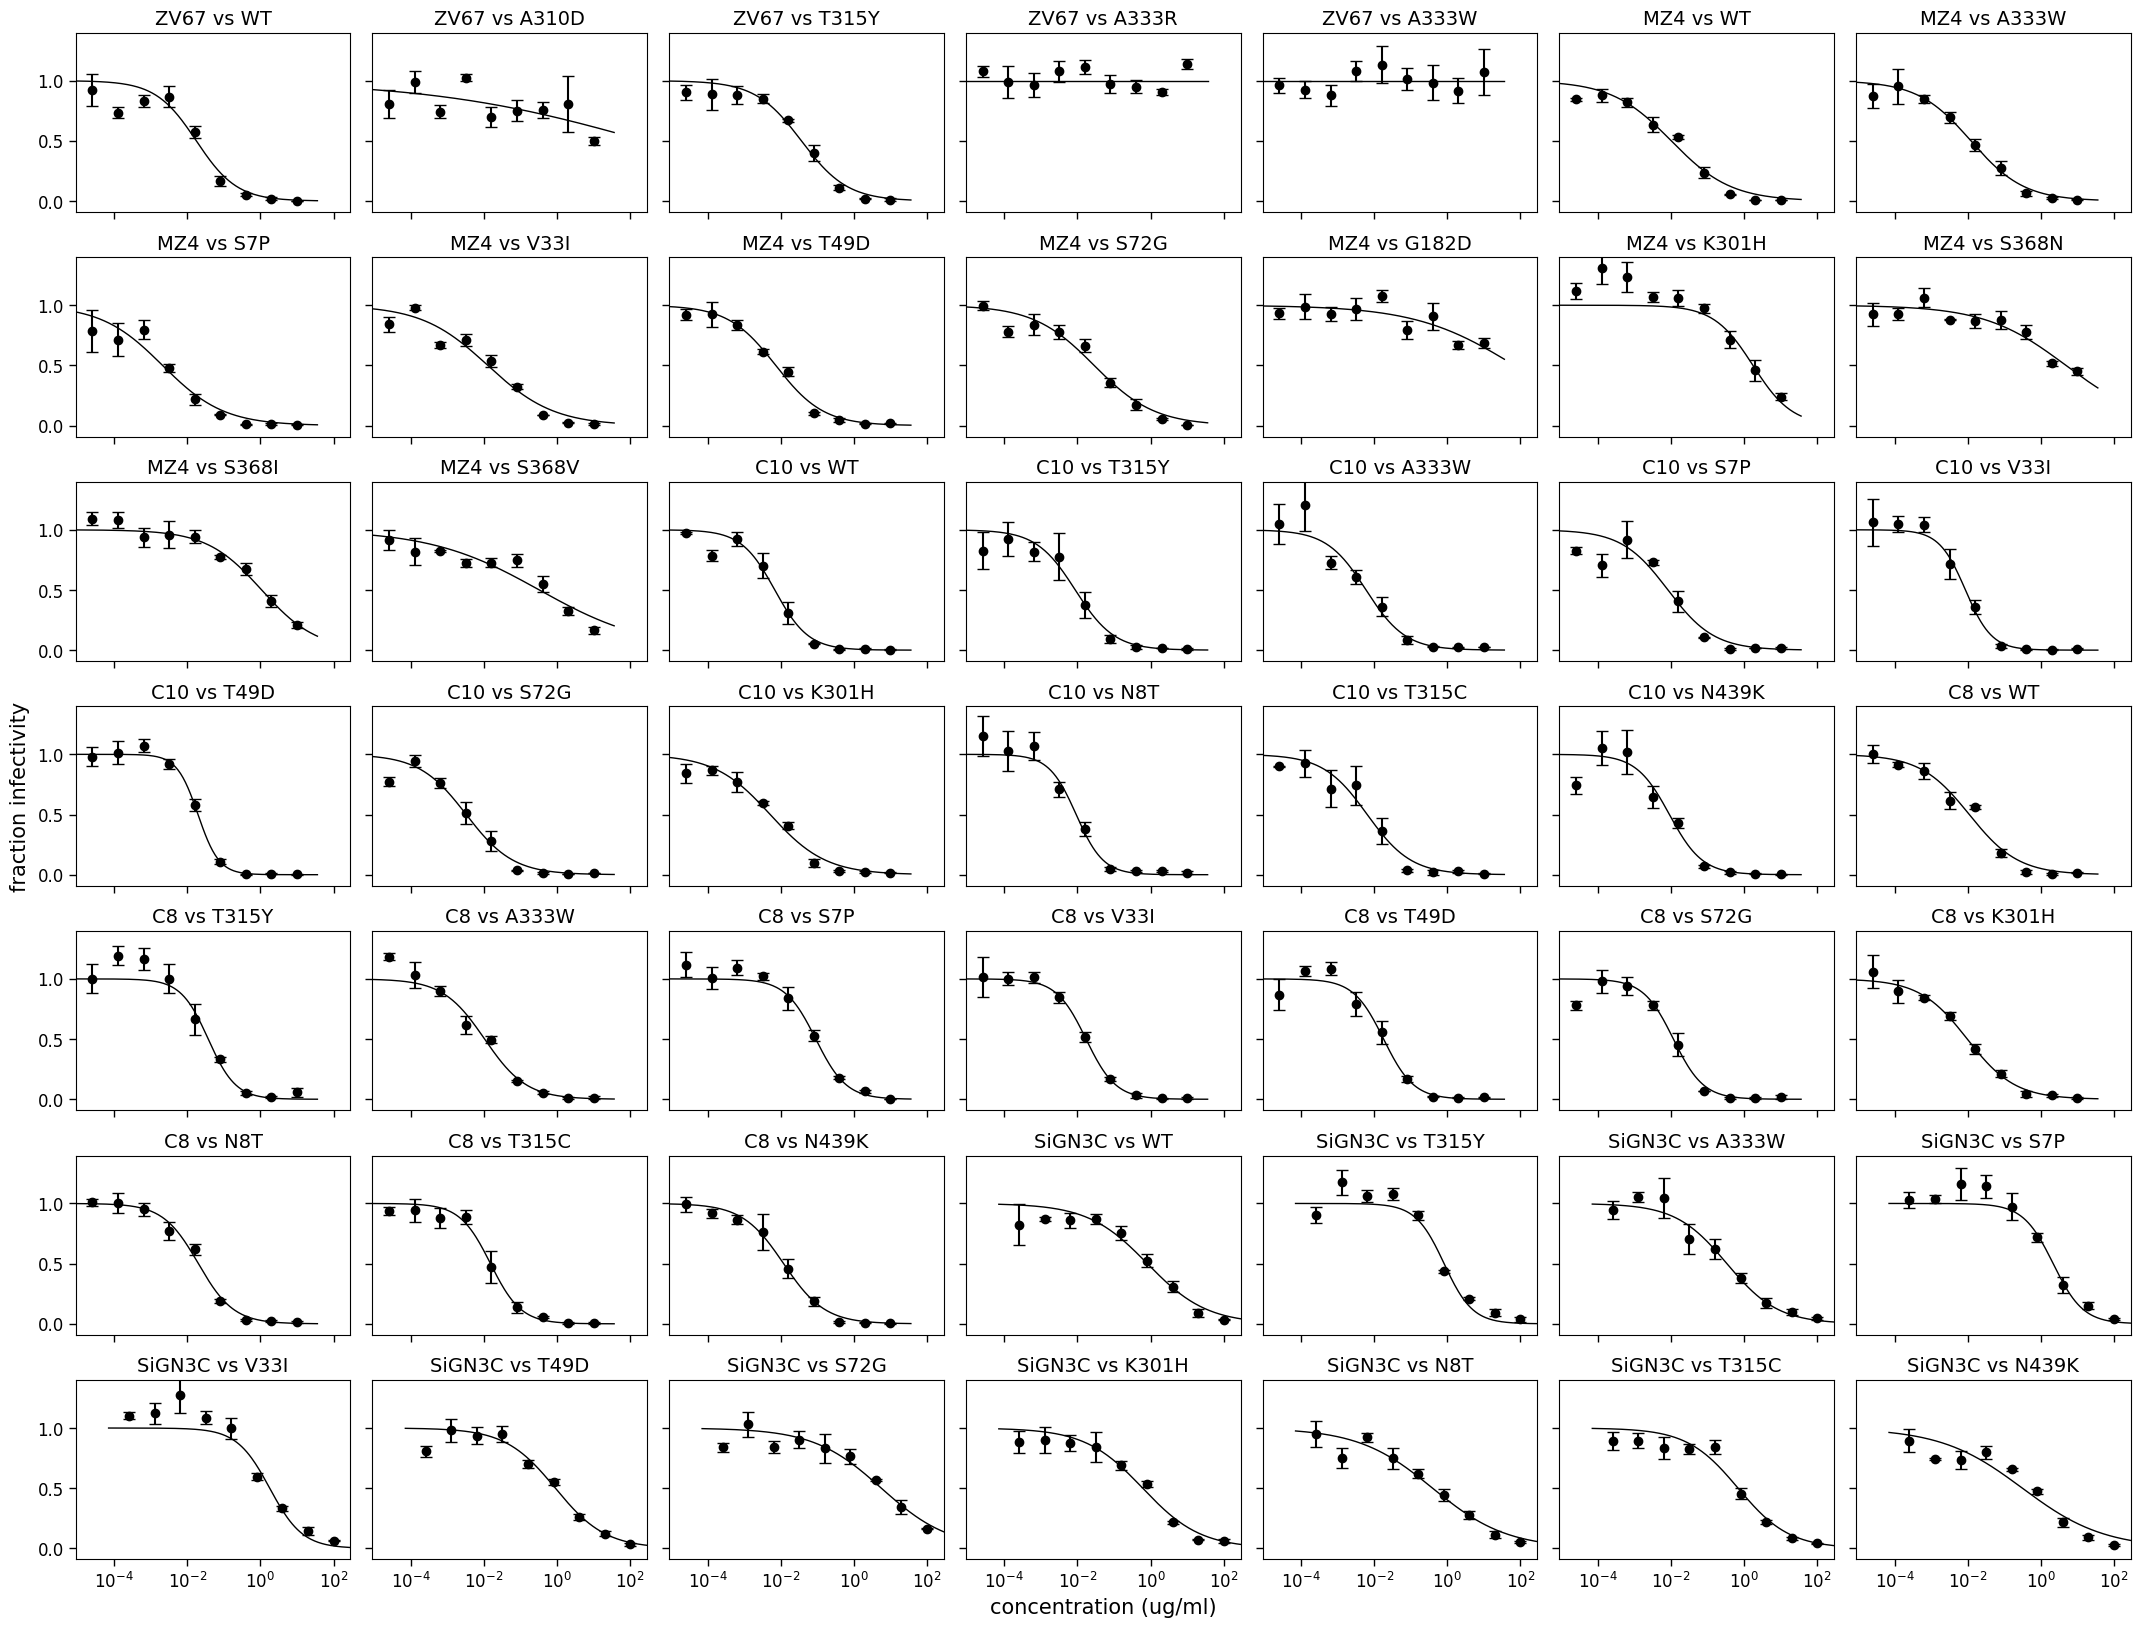

In [8]:
# For supplement, we might want to show all average curves
fig, axes = fits.plotAverages(sera = ['ZV67', 'MZ4', 'C10', 'C8', 'SiGN3C'],
                              ncol = 7,
                              xlabel='concentration (ug/ml)')

neutfile = os.path.join(resultsdir, 'replicate_ZikaMR766_neutcurves.pdf')
fig.savefig(neutfile, dpi='figure', bbox_inches='tight')

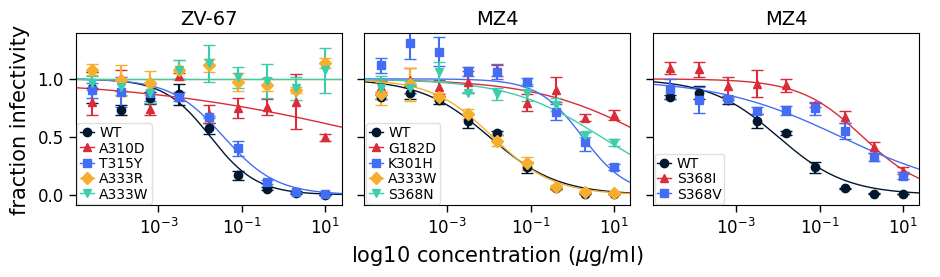

In [9]:
virus_subset_Targeted = ['WT', 'A333W', 'K301H','T315Y',
       'G182D', 'S368I', 'S368N', 'S368V', 'A333R',
       'A310D']

fig, axes = fits.plotSera(max_viruses_per_subplot=5,
              colors = colorwheel,
                          ncol = 3,
                          xlabel='log10 concentration ($\mu$g/ml)',
                          ylabel= 'fraction infectivity',
                          sera=['ZV67', 'MZ4'],
                          viruses = virus_subset_Targeted,
                          titles=['ZV-67', 'MZ4'],
              legendfontsize=10,
                         )

# _ = axes.ravel()[-1].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
_ = axes.ravel()[-1].set_yticks([0.0,0.5,1.0])
# _ = axes.ravel()[-1].set_xticks([1e-4, 1e-2, 1e0, 1e2,])

# fig.tight_layout()

neutfile = os.path.join(resultsdir, 'targeted_vs_MR766.pdf')
fig.savefig(neutfile, dpi='figure', bbox_inches='tight')

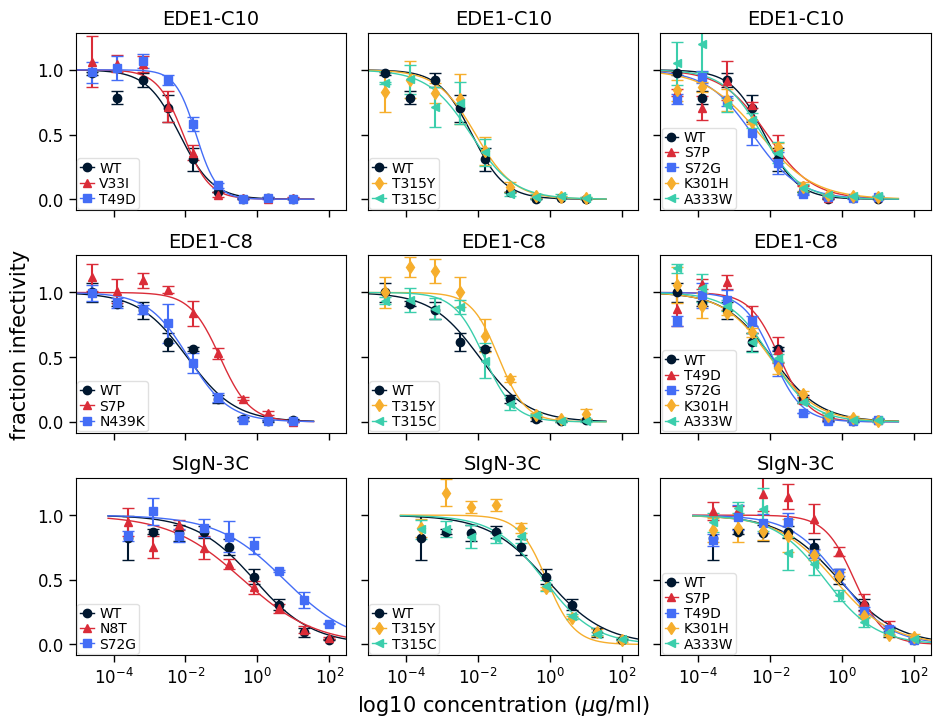

In [10]:
# Big layout for paper figure
# Markers
m = 'o'
fig, axes = fits.plotGrid(
                {
                 # row 1, column 1: C10 versus V33I, T49D, 
                 (0, 0): ('EDE1-C10',
                          [{'serum': 'C10', 'virus': 'WT',
                            'replicate': 'average', 'color': colorwheel[0],
                             'marker': 'o', 'label':'WT'},
                           {'serum': 'C10', 'virus': 'V33I',
                            'replicate': 'average', 'color': colorwheel[1],
                            'marker': '^', 'label':'V33I'},
                           {'serum': 'C10', 'virus': 'T49D',
                            'replicate': 'average', 'color': colorwheel[2],
                            'marker': 's', 'label':'T49D'},
]
                          ),
                 # row 1, column 2: C10 versus T315Y, T315C
                 (0, 1): ('EDE1-C10',
                          [{'serum': 'C10', 'virus': 'WT',
                            'replicate': 'average', 'color': colorwheel[0],
                            'marker': 'o', 'label':'WT'},
                           {'serum': 'C10', 'virus': 'T315Y',
                            'replicate': 'average', 'color': colorwheel[3],
                            'marker': 'd', 'label':'T315Y'},
                           {'serum': 'C10', 'virus': 'T315C',
                            'replicate': 'average', 'color': colorwheel[4],
                            'marker': '<', 'label':'T315C'}]
                          ),
                 # row 1, column 3: C10 versus neg controls
                 (0, 2): ('EDE1-C10',
                          [{'serum': 'C10', 'virus': 'WT',
                            'replicate': 'average', 'color': colorwheel[0],
                            'marker': 'o', 'label':'WT'},
                           {'serum': 'C10', 'virus': 'S7P',
                            'replicate': 'average', 'color': colorwheel[1],
                            'marker': '^', 'label':'S7P'},
                           {'serum': 'C10', 'virus': 'S72G',
                            'replicate': 'average', 'color': colorwheel[2],
                            'marker': 's', 'label':'S72G'},
                           {'serum': 'C10', 'virus': 'K301H',
                            'replicate': 'average', 'color': colorwheel[3],
                            'marker': 'd', 'label':'K301H'},
                           {'serum': 'C10', 'virus': 'A333W',
                            'replicate': 'average', 'color': colorwheel[4],
                            'marker': '<', 'label':'A333W'}]
                          ),
                    
                    
                 # row 2, column 1: C8 versus S7P, N439K
                 (1, 0): ('EDE1-C8',
                          [{'serum': 'C8', 'virus': 'WT',
                            'replicate': 'average', 'color': colorwheel[0],
                            'marker': 'o', 'label':'WT'},
                           {'serum': 'C8', 'virus': 'S7P',
                            'replicate': 'average', 'color': colorwheel[1],
                            'marker': '^', 'label':'S7P'},
                           {'serum': 'C8', 'virus': 'N439K',
                            'replicate': 'average', 'color': colorwheel[2],
                            'marker': 's', 'label':'N439K'},]
                          ),
                 # row 2, column 2: C8 versus T315Y, T315C
                 (1, 1): ('EDE1-C8',
                          [{'serum': 'C8', 'virus': 'WT',
                            'replicate': 'average', 'color': colorwheel[0],
                            'marker': 'o', 'label':'WT'},
                           {'serum': 'C8', 'virus': 'T315Y',
                            'replicate': 'average', 'color': colorwheel[3],
                            'marker': 'd', 'label':'T315Y'},
                           {'serum': 'C8', 'virus': 'T315C',
                            'replicate': 'average', 'color': colorwheel[4],
                            'marker': '<', 'label':'T315C'}]
                          ),
                 # row 2, column 3: C8 versus neg controls
                 (1, 2): ('EDE1-C8',
                          [{'serum': 'C8', 'virus': 'WT',
                            'replicate': 'average', 'color': colorwheel[0],
                            'marker': 'o', 'label':'WT'},
                           {'serum': 'C8', 'virus': 'T49D',
                            'replicate': 'average', 'color': colorwheel[1],
                            'marker': '^', 'label':'T49D'},
                           {'serum': 'C8', 'virus': 'S72G',
                            'replicate': 'average', 'color': colorwheel[2],
                            'marker': 's', 'label':'S72G'},
                           {'serum': 'C8', 'virus': 'K301H',
                            'replicate': 'average', 'color': colorwheel[3],
                            'marker': 'd', 'label':'K301H'},
                           {'serum': 'C8', 'virus': 'A333W',
                            'replicate': 'average', 'color': colorwheel[4],
                            'marker': '<', 'label':'A333W'}]
                          ),
                    
                
                 # row 3, column 1: SIgN-3C versus N8T, S72G, 
                 (2, 0): ('SIgN-3C',
                          [{'serum': 'SiGN3C', 'virus': 'WT',
                            'replicate': 'average', 'color': colorwheel[0],
                            'marker': 'o', 'label':'WT'},
                           {'serum': 'SiGN3C', 'virus': 'N8T',
                            'replicate': 'average', 'color': colorwheel[1],
                            'marker': '^', 'label':'N8T'},
                           {'serum': 'SiGN3C', 'virus': 'S72G',
                            'replicate': 'average', 'color': colorwheel[2],
                            'marker': 's', 'label':'S72G'},]
                          ),
                 # row 3, column 2: SIgN-3C versus T315Y, T315C
                 (2, 1): ('SIgN-3C',
                          [{'serum': 'SiGN3C', 'virus': 'WT',
                            'replicate': 'average', 'color': colorwheel[0],
                            'marker': 'o', 'label':'WT'},
                           {'serum': 'SiGN3C', 'virus': 'T315Y',
                            'replicate': 'average', 'color': colorwheel[3],
                            'marker': 'd', 'label':'T315Y'},
                           {'serum': 'SiGN3C', 'virus': 'T315C',
                            'replicate': 'average', 'color': colorwheel[4],
                            'marker': '<', 'label':'T315C'}
                        
]
                          ),
                 # row 3, column 3: SIgN-3C versus neg controls
                 (2, 2): ('SIgN-3C',
                          [{'serum': 'SiGN3C', 'virus': 'WT',
                            'replicate': 'average', 'color': colorwheel[0],
                            'marker': 'o', 'label':'WT'},
                           {'serum': 'SiGN3C', 'virus': 'S7P',
                            'replicate': 'average', 'color': colorwheel[1],
                            'marker': '^', 'label':'S7P'},
                           {'serum': 'SiGN3C', 'virus': 'T49D',
                            'replicate': 'average', 'color': colorwheel[2],
                            'marker': 's', 'label':'T49D'},
                           {'serum': 'SiGN3C', 'virus': 'K301H',
                            'replicate': 'average', 'color': colorwheel[3],
                            'marker': 'd', 'label':'K301H'},
                           {'serum': 'SiGN3C', 'virus': 'A333W',
                            'replicate': 'average', 'color': colorwheel[4],
                            'marker': '<', 'label':'A333W'}]
                          ),
                 
                 },
                legendfontsize=10,
                xlabel='log10 concentration ($\mu$g/ml)',
                ylabel= 'fraction infectivity'
                )

# _ = axes.ravel()[-1].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
_ = axes.ravel()[-1].set_yticks([0.0,0.5,1.0])
_ = axes.ravel()[-1].set_xticks([1e-4, 1e-2, 1e0, 1e2,])

# fig.tight_layout()

neutfile = os.path.join(resultsdir, 'Broad_vs_MR766.pdf')
fig.savefig(neutfile, dpi='figure', bbox_inches='tight')